In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

In [7]:
# 데이터 로드
(train, val, test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]','train[90%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 180       # 해상도 : 180 X 180


# 이미지 리사이즈 함수 생성
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds_resized = train.map(format_image)
val_ds_resized = val.map(format_image)
test_ds_resized = test.map(format_image)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_ds_batch = train_ds_resized.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds_batch = val_ds_resized.batch(BATCH_SIZE)
test_ds_batch = test_ds_resized.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.9FTNXY_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [8]:
base_model = EfficientNetV2B0(
    input_shape=(180, 180, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

In [9]:
model = Sequential([

    # 데이터 증강
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),

    # 베이스 모델
    base_model,
    GlobalAveragePooling2D(),

    # 드롭아웃 규제 적용
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(train_ds_batch,
                    validation_data=val_ds_batch,
                    epochs=15,
                    verbose=1)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5281 - loss: 1.2450 - val_accuracy: 0.8338 - val_loss: 0.5361
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8182 - loss: 0.5773 - val_accuracy: 0.8692 - val_loss: 0.3854
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8454 - loss: 0.4513 - val_accuracy: 0.8828 - val_loss: 0.3248
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.8742 - loss: 0.3698 - val_accuracy: 0.8856 - val_loss: 0.3075
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8890 - loss: 0.3339 - val_accuracy: 0.9046 - val_loss: 0.2802
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9004 - loss: 0.3082 - val_accuracy: 0.9074 - val_loss: 0.2689
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8956 - loss: 0.2908 - val_accuracy: 0.9210 - val_loss: 0.2571
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9171 - loss: 0.2590 - val_accuracy: 0.9264 - v

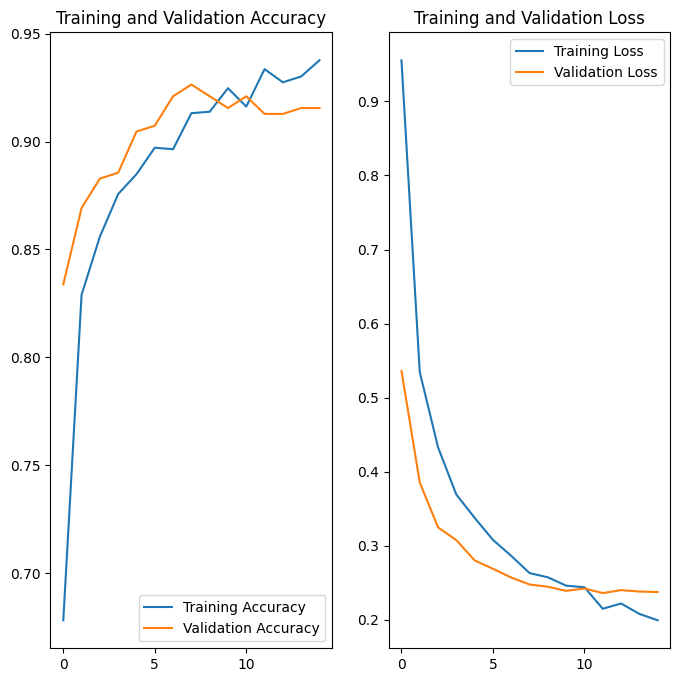

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# TTA(Test Time Augmentation) : 원본 이미지 예측 확률과 좌우 반전된 이미지 예측 확률의 평균이용
def get_tta_prediction(model, dataset):
    # 원본 이미지로 예측
    pred_orig = model.predict(dataset)

    # 좌우 반전된 이미지로 예측
    flipped_ds = dataset.map(lambda x, y: (tf.image.flip_left_right(x), y))
    pred_flip = model.predict(flipped_ds)

    # 3. 두 결과 평균
    return (pred_orig + pred_flip) / 2

final_pred = get_tta_prediction(model, test_ds_batch)

y_test = np.concatenate([y for x, y in test_ds_batch], axis=0)
final_acc = np.mean(np.argmax(final_pred, axis=1) == y_test)

print(f"1차 최종 정확도 (EfficientNet + TTA): {final_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
1차 최종 정확도 (EfficientNet + TTA): 0.9319


In [14]:
# Fine-Tuning

base_model.trainable = True

# 모델 재컴파일 -> 라벨 스무딩 적용으로 애매한 데이터에 강건하게
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# SparseCategorical의 경우 라벨 스무딩 인자를 지원 X -> 학습 횟수를 더 증가
fine_tune_epochs = 15
total_epochs = 15 + fine_tune_epochs

history_fine = model.fit(
    train_ds_batch,
    validation_data=val_ds_batch,
    initial_epoch=history.epoch[-1], # 아까 끝난 시점부터 이어서
    epochs=total_epochs,
    verbose=1
)

final_pred_fine = get_tta_prediction(model, test_ds_batch)

y_test = np.concatenate([y for x, y in test_ds_batch], axis=0)
final_acc_fine = np.mean(np.argmax(final_pred_fine, axis=1) == y_test)

print(f"Fine-Tuning 후 최종 정확도: {final_acc_fine:.4f}")

Epoch 15/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - accuracy: 0.7672 - loss: 0.6911 - val_accuracy: 0.8283 - val_loss: 0.5084
Epoch 16/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 577s 6s/step - accuracy: 0.8157 - loss: 0.5694 - val_accuracy: 0.8583 - val_loss: 0.4539
Epoch 17/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.8577 - loss: 0.4529 - val_accuracy: 0.8774 - val_loss: 0.4143
Epoch 18/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 513s 6s/step - accuracy: 0.8623 - loss: 0.4229 - val_accuracy: 0.8719 - val_loss: 0.3828
Epoch 19/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 524s 6s/step - accuracy: 0.8649 - loss: 0.3892 - val_accuracy: 0.8774 - val_loss: 0.3643
Epoch 20/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 552s 6s/step - accuracy: 0.9017 - loss: 0.3326 - val_accuracy: 0.8856 - val_loss: 0.3444
Epoch 21/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 565s 6s/step - accuracy: 0.8949 - loss: 0.3163 - val_accuracy: 0.8992 - val_loss: 0.3166
Epoch 22/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step - accuracy: 0.9128 - loss: 0.2913 - val_accuracy: 0.

In [15]:
# 모델 저장 및 불러오기 코드 (구조 + 가중치)
model.save('my_best_flower_model.keras')

print("✅ 모델 저장이 완료되었습니다! 'my_best_flower_model.keras' 파일을 확인하세요.")

# loaded_model = tf.keras.models.load_model('my_best_flower_model.keras')

✅ 모델 저장이 완료되었습니다! 'my_best_flower_model.keras' 파일을 확인하세요.
